In [1]:
import sys
print(f'Working with Python {sys.version}')

import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import rdkit.Chem.Descriptors as Descriptors
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt
import seaborn as sns
import os
#import pymzml
import numpy as np
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')



# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
import fiora.IO.mspReader as mspReader
import fiora.IO.mgfReader as mgfReader
import fiora.visualization.spectrum_visualizer as sv


Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


In [2]:

p = pd.DataFrame(mspReader.read(f"{home}/data/metabolites/MS_DIAL/MSMS_Public_EXP_Pos_VS17.msp", sep="\t"))
n = pd.DataFrame(mspReader.read(f"{home}/data/metabolites/MS_DIAL/MSMS_Public_EXP_NEG_VS17.msp", sep="\t"))
df = pd.concat([p, n])


In [4]:
df.shape

(368860, 15)

In [ ]:

df[df["CE_float"]]["INSTRUMENTTYPE"].value_counts()

QTOF                     127366
Orbitrap                  99941
LC-ESI-QFT                 7299
Linear Ion Trap            6657
Flow-injection QqQ/MS      3897
LC-ESI-QTOF                 924
LC-ESI-TOF                  866
LC-ESI-IT                   304
QqQ                         163
LC-ESI-QQ                    42
QIT                          40
LC-APCI-ITFT                  8
LC-ESI-ITFT                   4
Name: INSTRUMENTTYPE, dtype: int64

In [4]:
df["origin"] = "Untracked"
for i, d in df.iterrows():
    try:
        df.at[i, "origin"] = d["COMMENT"].split("origin=")[1]
    except:
        if "MetaboBASE" in d["COMMENT"]: 
            df.at[i, "origin"] = "MetaboBASE"

In [5]:
df["origin"].value_counts()

BMDMS-NP                                                                             227307
Vaniya/Fiehn Natural Products Library                                                 57786
MassBank High Quality Mass Spectral Database                                          46699
RIKEN Plant Specialized Metabolome Annotation (PlaSMA) Authentic Standard Library     12871
RIKEN MS^n Spectral Database for Phytochemicals                                        8869
Global Natural Product Social Molecular Networking Library                             8326
Fiehn Lab HILIC Library                                                                2696
Bruker Sumner MetaboBASE Plant Library                                                 1732
EMBL - Metabolomics Core Facility Spectral Library                                     1202
RIKEN IMS Oxidized Phospholipids                                                        772
Pathogen Box                                                                    

<AxesSubplot: xlabel='RETENTIONTIME', ylabel='Count'>

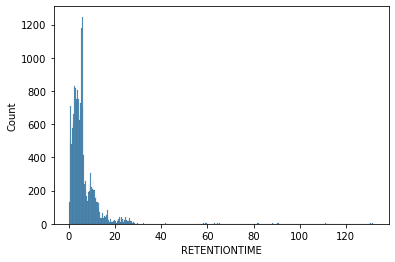

In [6]:
sns.histplot(df[df["origin"] == "Vaniya/Fiehn Natural Products Library"]["RETENTIONTIME"].astype(float))

In [7]:
df["RETENTIONTIME"] = df["RETENTIONTIME"].astype(float)
df.reset_index(inplace=True)

In [ ]:
#df["SMILES"].apply(Chem.MolFromSmiles).isna().any()

(0.0, 20.0)

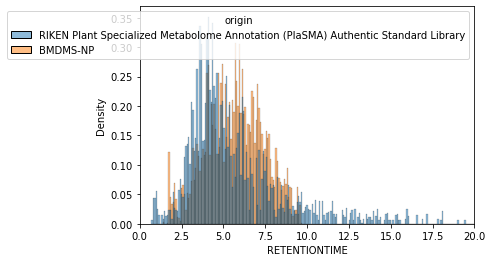

In [21]:
potential_homogenous_RT_libs = ["RIKEN Plant Specialized Metabolome Annotation (PlaSMA) Authentic Standard Library", 'BMDMS-NP'] #, 'Vaniya/Fiehn Natural Products Library']#, "Global Natural Product Social Molecular Networking Library"]

sns.histplot(data=df[df["origin"].isin(potential_homogenous_RT_libs)], x="RETENTIONTIME", hue="origin", common_norm=False, stat="density")
plt.xlim([0,20])

In [17]:
sns.histplot(df["SMILES"], )
df["origin"].value_counts()

BMDMS-NP                                                                             227307
Vaniya/Fiehn Natural Products Library                                                 57786
MassBank High Quality Mass Spectral Database                                          46699
RIKEN Plant Specialized Metabolome Annotation (PlaSMA) Authentic Standard Library     12871
RIKEN MS^n Spectral Database for Phytochemicals                                        8869
Global Natural Product Social Molecular Networking Library                             8326
Fiehn Lab HILIC Library                                                                2696
Bruker Sumner MetaboBASE Plant Library                                                 1732
EMBL - Metabolomics Core Facility Spectral Library                                     1202
RIKEN IMS Oxidized Phospholipids                                                        772
Pathogen Box                                                                    

In [ ]:
BMDMS = df[df["origin"] == "BMDMS-NP"]

In [ ]:
print(len(BMDMS["SMILES"].unique()))
print(BMDMS["PRECURSORTYPE"].value_counts())

2581
[M+H]+     114855
[M+Na]+    112452
Name: PRECURSORTYPE, dtype: int64


<AxesSubplot: xlabel='RETENTIONTIME', ylabel='Count'>

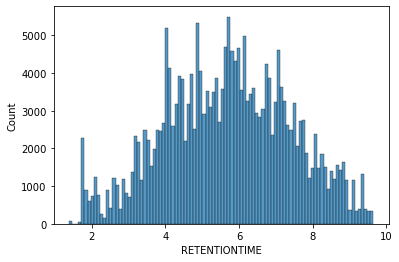

In [ ]:
sns.histplot(BMDMS["RETENTIONTIME"].astype(float))

In [ ]:
precursor_types = ["[M+H]+", "[M-H]-"]

df = df[df["PRECURSORTYPE"].apply(lambda x: x in precursor_types)]


In [ ]:
from modules.MOL.collision_energy import align_CE

df["PRECURSORMZ"] = df["PRECURSORMZ"].astype(float)
df["CE"] = df.apply(lambda x: align_CE(x["COLLISIONENERGY"], x["PRECURSORMZ"], instrument=x["INSTRUMENTTYPE"]), axis=1)

In [ ]:
df["CE_type"] = df["CE"].apply(type)
print(df["CE_type"].value_counts())
print(sum(df["CE"] == "")) # TODO assign random CE or 35 NCE ??)

<class 'float'>    196060
<class 'str'>       18708
Name: CE_type, dtype: int64
13162


In [ ]:
ce = df[df["CE_type"] == str]
ce["CE"].value_counts()[:20]

                       13162
HCD (NCE 20-30-40%)     1968
Ramp 5-60                799
Ramp 5-45                748
30-50                    217
65  FT-MS                 57
35  FT-MS                 57
35  FT-MS II              57
0.3->2                    46
35  IT-MS                 36
0.7                       36
Ramp 20-30                34
0.6                       29
20->80                    27
15->55                    25
20->10                    23
30->34%                   21
6->10                     21
60 NCE                    20
10->40                    19
Name: CE, dtype: int64

In [ ]:
ce[(ce["CE"] == "")]["origin"].value_counts()

MassBank High Quality Mass Spectral Database                  7628
Global Natural Product Social Molecular Networking Library    5291
RIKEN MS^n Spectral Database for Phytochemicals                146
Vaniya/Fiehn Natural Products Library                           97
Name: origin, dtype: int64

<AxesSubplot: xlabel='m/z', ylabel='Intensity'>

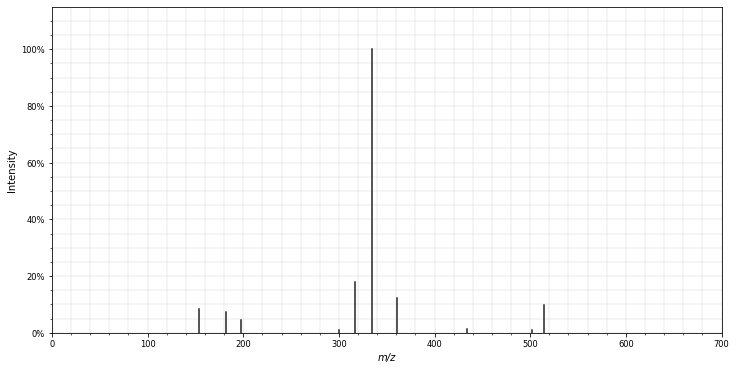

In [ ]:
sv.plot_spectrum(ce[(ce["CE"] == "")].iloc[0])

In [ ]:
df = df[df["CE_type"] == float]
df["CE"] = df["CE"].astype(float)
df = df[df["CE"] <= 1000.0]
df.reset_index(inplace=True)


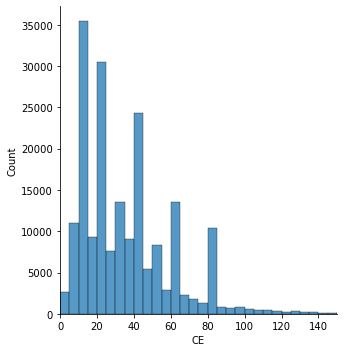

(196059, 20)


In [ ]:

sns.displot(data=df, x="CE", binwidth=5, kde=False)
plt.xlim([0, 150])
plt.show()
print(df.shape)

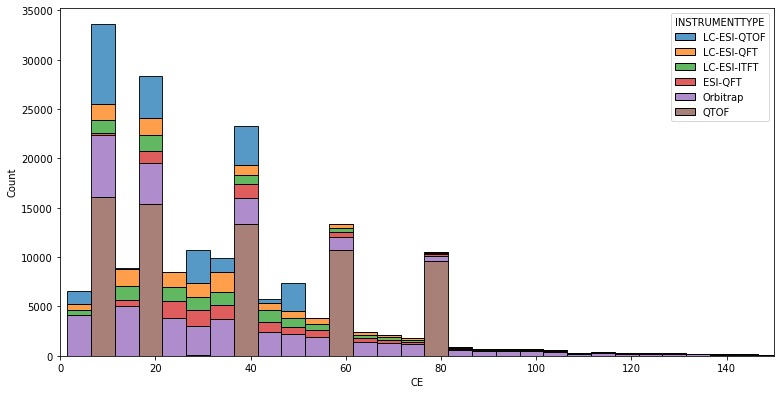

(196059, 20)


In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12.8, 6.4), sharey=False)


top_instrumenttypes = df['INSTRUMENTTYPE'].value_counts().head(6).index
sns.histplot(data=df[df['INSTRUMENTTYPE'].isin(top_instrumenttypes)], x="CE", hue="INSTRUMENTTYPE", multiple="stack", binwidth=5, kde=False)
plt.xlim([0, 150])
plt.show()
print(df.shape)

In [ ]:
from modules.MOL.Metabolite import Metabolite

df["Metabolite"] = df["SMILES"].apply(Metabolite)


In [ ]:
from modules.MOL.constants import ADDUCT_WEIGHTS, PPM

df["Precursor_offset"] = df["PRECURSORMZ"] - df.apply(lambda x: x["Metabolite"].ExactMolWeight + ADDUCT_WEIGHTS[x["PRECURSORTYPE"]], axis=1)
df["Precursor_abs_error"] = abs(df["Precursor_offset"])
df["Precursor_rel_error"] = df["Precursor_abs_error"] / df["PRECURSORMZ"]
df["Precursor_ppm_error"] = df["Precursor_abs_error"] / (df["PRECURSORMZ"] * PPM)
print((df["Precursor_ppm_error"] > 500).sum())
d = df[df["Precursor_ppm_error"] > 500].iloc[0]
print(d["Metabolite"].ExactMolWeight)
print(d["Metabolite"])
df["SMILES"].apply(lambda x: "+" in x).sum()

6160
744.0827287780902
<Metabolite: C1=CC(=C[N+](=C1)[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(O)OP(=O)(O)OC[C@@H]3[C@H]([C@H]([C@@H](O3)N4C=NC5=C(N=CN=C54)N)OP(=O)(O)O)O)O)O)C(=O)N>


6193

In [ ]:
%%capture
from modules.MOL.Metabolite import Metabolite
from modules.MOL.constants import PPM
TOLERANCE = 200 * PPM


df["Metabolite"] = df["SMILES"].apply(Metabolite)
df = df[df["Metabolite"].apply(lambda x: x.is_single_connected_structure())]
df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())
df["Metabolite"].apply(lambda x: x.compute_graph_attributes())
df["Metabolite"].apply(lambda x: x.fragment_MOL())
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=TOLERANCE), axis=1)

In [ ]:
# for i, d in df.iterrows():
#     fragments = Chem.GetMolFrags(d["Metabolite"].MOL, asMols=True)
#     if len(fragments) == 1:
#         d["Metabolite"].fragment_MOL()
#     else: 
#         try:
#             d["Metabolite"].fragment_MOL()
#             print("Unexpected")
#             print(i, d)
#         except:
#             print("Expected")


In [ ]:
# Define figure styles
color_palette = sns.color_palette("magma_r", 8)
sns.set_theme(style="whitegrid",
                  rc={'axes.edgecolor': 'black', 'ytick.left': True, 'xtick.bottom': True, 'xtick.color': 'black',
                      "axes.spines.bottom": True, "axes.spines.right": True, "axes.spines.top": True,
                      "axes.spines.left": True})

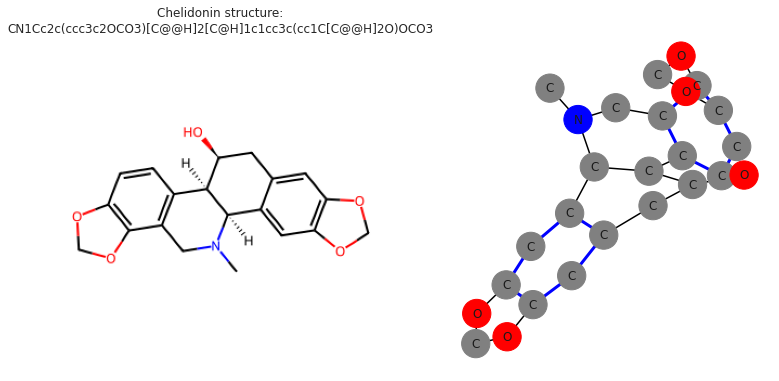

{'mz': [135.044, 247.075, 265.085, 275.069, 276.072, 277.076, 293.08, 295.095, 296.098, 303.064, 305.079, 306.083, 307.089, 323.09, 324.093, 325.096, 334.106, 336.121, 337.124, 352.116, 353.119, 354.132, 355.135, 356.137], 'intensity': [10.0, 46.0, 11.0, 489.0, 87.0, 10.0, 19.0, 71.0, 12.0, 15.0, 394.0, 76.0, 14.0, 368.0, 69.0, 10.0, 10.0, 81.0, 17.0, 51.0, 12.0, 1000.0, 208.0, 27.0], 'annotation': []}


In [ ]:
from modules.MOL.mol_graph import draw_graph
x = df.iloc[0]
x_mol = x["Metabolite"].MOL
fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), gridspec_kw={'width_ratios': [1, 1]}, sharey=False)

img = Chem.Draw.MolToImage(x_mol, ax=axs[0])

axs[0].grid(False)
axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False)
axs[0].set_title(x["NAME"]+ " structure:\n" + Chem.MolToSmiles(x_mol))
axs[0].imshow(img)
axs[0].axis("off")

g_img = draw_graph(x["Metabolite"].Graph, ax=axs[1])
print(x["peaks"])

In [ ]:
from modules.MOL.constants import DEFAULT_MODES
df["peak_matches"] = df["Metabolite"].apply(lambda x: getattr(x, "peak_matches"))
df["num_peaks_matched"] = df["peak_matches"].apply(len)

def get_match_stats(matches, mode_count={m: 0 for m in DEFAULT_MODES}):
    num_unique, num_conflicts = 0, 0
    for mz, match_data in matches.items():
        #candidates = match_data["fragments"]
        ion_modes = match_data["ion_modes"]
        if len(ion_modes) == 1:
            num_unique += 1
        elif len(ion_modes) > 1:
            num_conflicts += 1
        for c in ion_modes:
            mode_count[c[0]] += 1
    return num_unique, num_conflicts, mode_count



df["match_stats"] = df["peak_matches"].apply(lambda x: get_match_stats(x))
df["num_unique_peaks_matched"] = df.apply(lambda x: x["match_stats"][0], axis=1)
df["num_conflicts_in_peak_matching"] = df.apply(lambda x: x["match_stats"][1], axis=1)
df["match_mode_counts"] = df.apply(lambda x: x["match_stats"][2], axis=1)
u= df["num_unique_peaks_matched"].sum() 
s= df["num_conflicts_in_peak_matching"].sum() 
print(f"Total number of uniquely matched peaks: {u} , conflicts found within {s} matches ({100 * s / (u+s):.02f} %))")
print(f"Total number of conflicting peak to fragment matches: {s}")

/tmp/ipykernel_851052/463457465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["peak_matches"] = df["Metabolite"].apply(lambda x: getattr(x, "peak_matches"))
/tmp/ipykernel_851052/463457465.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["num_peaks_matched"] = df["peak_matches"].apply(len)
/tmp/ipykernel_851052/463457465.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

Total number of uniquely matched peaks: 527811 , conflicts found within 97672 matches (15.62 %))
Total number of conflicting peak to fragment matches: 97672


/tmp/ipykernel_851052/463457465.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["match_mode_counts"] = df.apply(lambda x: x["match_stats"][2], axis=1)


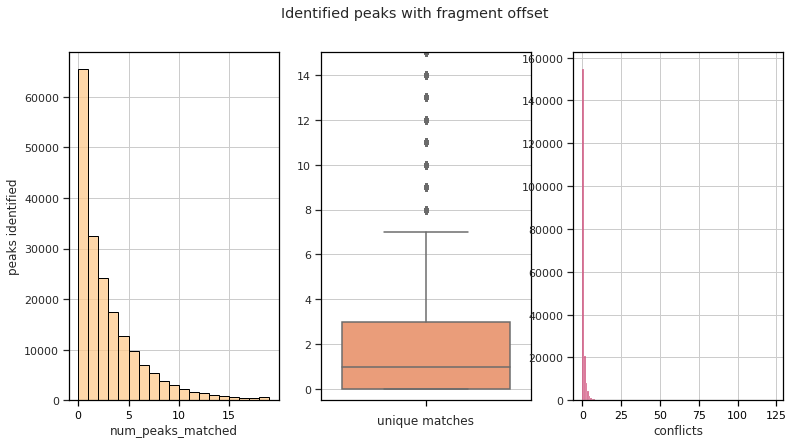

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12.8, 6.4), sharey=False)

fig.suptitle(f"Identified peaks with fragment offset")
#plt.title(f"Identified peaks with fragment offset: {str(off)}")
sns.histplot(ax=axs[0],data=df, x="num_peaks_matched", color=color_palette[0], edgecolor="black", bins=range(0,20, 1))
#axs[0].set_ylim(-0.5, 10)
axs[0].set_ylabel("peaks identified")


sns.boxplot(ax=axs[1],data=df, y="num_unique_peaks_matched", color=color_palette[1])
axs[1].set_ylim(-0.5, 15)
axs[1].set_xlabel("unique matches")
axs[1].set_ylabel("")


sns.histplot(ax=axs[2],data=df, x="num_conflicts_in_peak_matching", color=color_palette[3], binwidth=1)
#axs[2].set_ylim(-0.5, 1000)
axs[2].set_xlabel("conflicts")
axs[2].set_ylabel("")

plt.show()

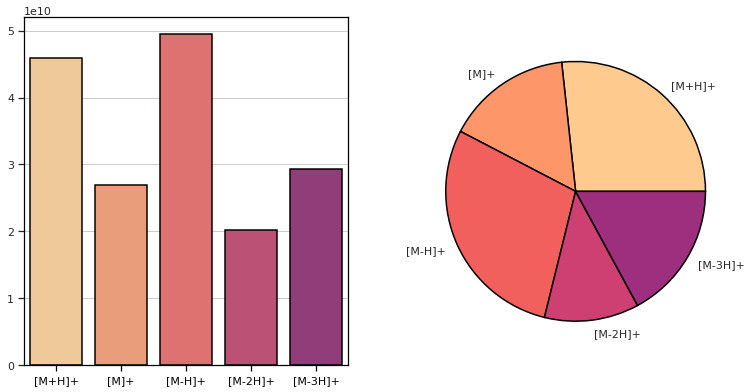

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), sharey=False)

mode_counts = {m: 0 for m in DEFAULT_MODES}

def update_mode_counts(m):
    for mode in m.keys():
        mode_counts[mode] += m[mode]

df["match_mode_counts"].apply(update_mode_counts)

sns.barplot(ax=axs[0], x=list(mode_counts.keys()), y=[mode_counts[k] for k in mode_counts.keys()], palette=color_palette, edgecolor="black", linewidth=1.5)
axs[1].pie([mode_counts[k] for k in mode_counts.keys()], labels=list(mode_counts.keys()), colors=color_palette, wedgeprops={"edgecolor": "black", "linewidth": 1.5})

plt.show()

In [ ]:
# Add is in CASMI 2016 Info
import pandas as pd
from modules.MOL.Metabolite import Metabolite

casmi16_path = f"{home}/data/metabolites/CASMI_2016/casmi16_challenges_combined.csv"
df_cas = pd.read_csv(casmi16_path, index_col=[0], low_memory=False)
df_cas["Metabolite"] = df_cas["SMILES"].apply(Metabolite)
df.dropna(subset=["SMILES"], inplace=True)
df["in_casmi2016"] = False

for i,d in df_cas.iterrows():
    m = d["Metabolite"]
    
    for x,D in df.iterrows():
        M = D["Metabolite"]
        if (m == M):
            df.at[x, "in_casmi2016"] = True
del df_cas

/tmp/ipykernel_851052/2616585280.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["SMILES"], inplace=True)
/tmp/ipykernel_851052/2616585280.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["in_casmi2016"] = False


In [ ]:

for i in range(0,6):
    print(f"Minimum {i} unique peaks identified (including precursors): ", (df["num_unique_peaks_matched"] >= i).sum())


Minimum 0 unique peaks identified (including precursors):  193438
Minimum 1 unique peaks identified (including precursors):  123776
Minimum 2 unique peaks identified (including precursors):  86279
Minimum 3 unique peaks identified (including precursors):  61859
Minimum 4 unique peaks identified (including precursors):  45159
Minimum 5 unique peaks identified (including precursors):  33576


In [ ]:
# raise KeyboardInterrupt()

In [ ]:
df[(df["CE"] < 1)]["COLLISIONENERGY"]

1749        0
1752        0
1755        0
1758        0
1761        0
         ... 
186050    -20
186063    -20
186065    -12
186083    -35
186086    -14
Name: COLLISIONENERGY, Length: 344, dtype: object

In [ ]:
df[(df["CE"] < 1)]["COLLISIONENERGY"]

1749        0
1752        0
1755        0
1758        0
1761        0
         ... 
186050    -20
186063    -20
186065    -12
186083    -35
186086    -14
Name: COLLISIONENERGY, Length: 344, dtype: object

In [ ]:
raise KeyboardInterrupt()

In [ ]:
save_df = False
lib = f"{home}/data/metabolites/MS_DIAL/"
name = "ms_dial_filtered"
date = "XXX" # "mid_08_2023" #"mid_08_2023" #"07_2023"
min_peaks = 5

if save_df:
       file = lib + name + "_min" + str(min_peaks) + "_" + date + ".csv"
       print("saving to ", file)
       df[df["num_unique_peaks_matched"] >= min_peaks].to_csv(file)
       
       #df.to_csv(lib + name + "_all" + "_" + date + ".csv") #TODO HERE

saving to  /home/ynowatzk/data/metabolites/MS_DIAL/ms_dial_filtered_min5_mid_08_2023.csv


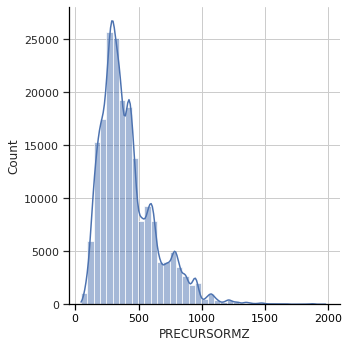

In [ ]:
sns.displot(df, x="PRECURSORMZ", kde=True, binwidth=50)
plt.show()

/tmp/ipykernel_851052/1632106418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RETENTIONTIME"] = df["RETENTIONTIME"].astype(float)


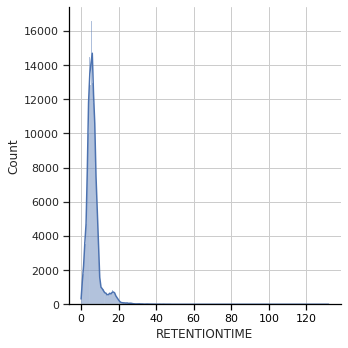

In [ ]:
df["RETENTIONTIME"] = df["RETENTIONTIME"].astype(float)
sns.displot(df, x="RETENTIONTIME", kde=True, binwidth=0.5)
plt.show()

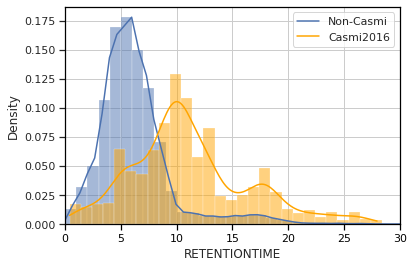

In [ ]:

sns.histplot(df[~df["in_casmi2016"]], x="RETENTIONTIME", kde=True, binwidth=1, stat="density", multiple="stack")
sns.histplot(df[df["in_casmi2016"]], x="RETENTIONTIME", kde=True, binwidth=1, stat="density", multiple="stack", color="orange")
plt.legend(labels=["Non-Casmi", "Casmi2016"])
plt.xlim([0,30])
plt.show()

/tmp/ipykernel_851052/2201103238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CCS"] = df["CCS"].astype(float)


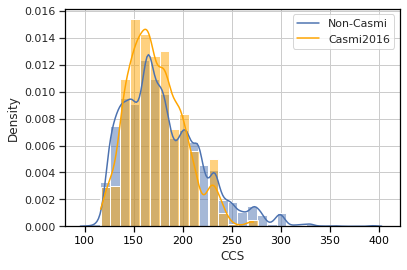

In [ ]:
df["CCS"] = df["CCS"].astype(float)
sns.histplot(df[~df["in_casmi2016"]], x="CCS", kde=True, binwidth=10, stat="density", multiple="stack")
sns.histplot(df[df["in_casmi2016"]], x="CCS", kde=True, binwidth=10, stat="density", multiple="stack", color="orange")
plt.legend(labels=["Non-Casmi", "Casmi2016"])

plt.show()

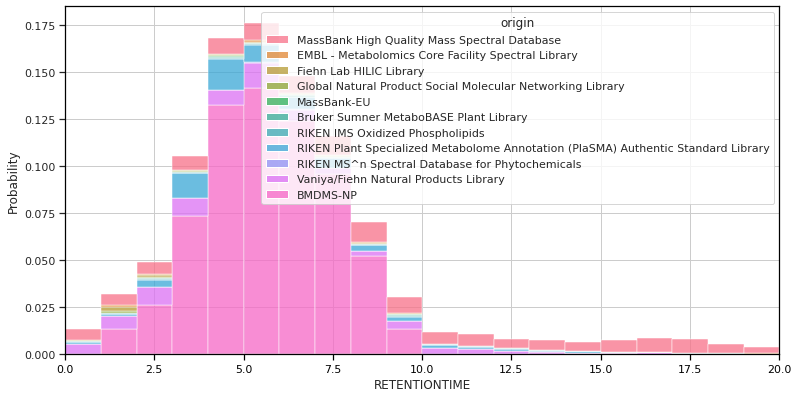

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(12.8, 6.4))

sns.histplot(ax=ax, data=df, x="RETENTIONTIME", hue='origin', multiple="stack", binwidth=1, stat="probability")
plt.xlim([0, 20])
plt.show()

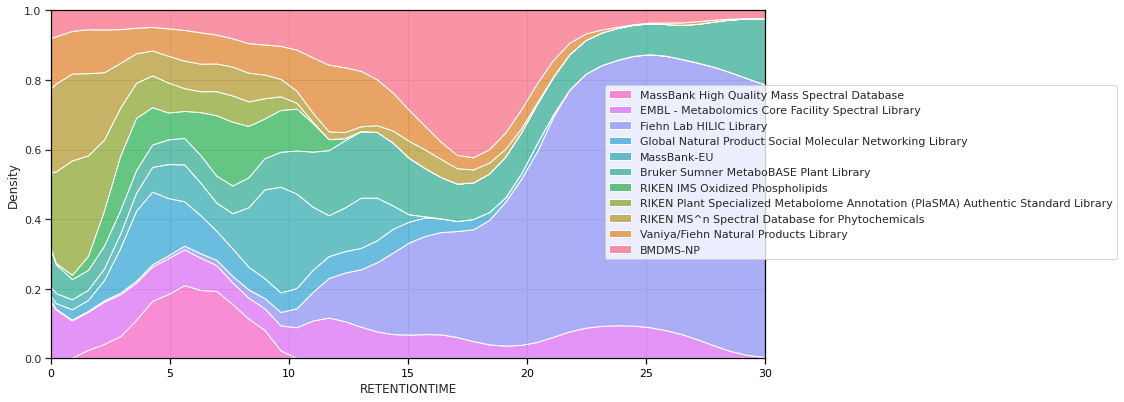

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(12.8, 6.4))

sns.kdeplot(ax=ax, data=df, x="RETENTIONTIME", hue='origin', multiple="fill", common_norm=False)
ax.legend(bbox_to_anchor=(1.5, 0.8), labels=df["origin"].unique())
plt.xlim([0, 30])
plt.show()
    
    

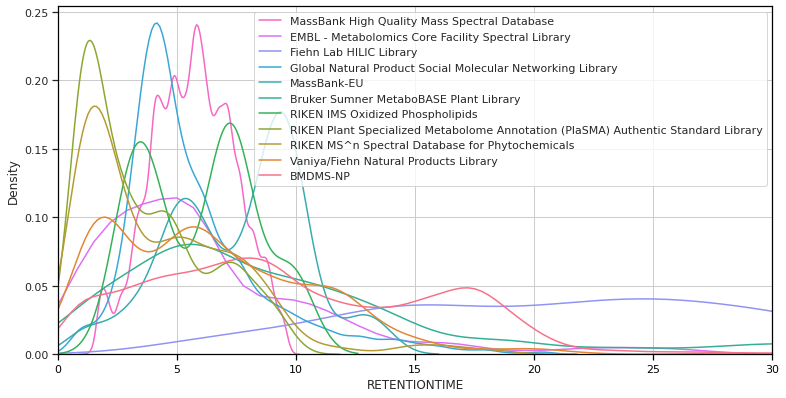

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(12.8, 6.4))

sns.kdeplot(ax=ax, data=df, x="RETENTIONTIME", hue='origin', multiple="layer", common_norm=False)
plt.legend(labels=df["origin"].unique())
plt.xlim([0, 30])
plt.show()

In [ ]:
df["origin"].value_counts()

BMDMS-NP                                                                             112495
Vaniya/Fiehn Natural Products Library                                                 29669
MassBank High Quality Mass Spectral Database                                          28151
RIKEN Plant Specialized Metabolome Annotation (PlaSMA) Authentic Standard Library     11587
RIKEN MS^n Spectral Database for Phytochemicals                                        6695
Bruker Sumner MetaboBASE Plant Library                                                 1532
Fiehn Lab HILIC Library                                                                1019
EMBL - Metabolomics Core Facility Spectral Library                                     1013
Global Natural Product Social Molecular Networking Library                              727
RIKEN IMS Oxidized Phospholipids                                                        386
MassBank-EU                                                                     

In [ ]:
print(len(df["SMILES"].unique()))
print(len(df[df["origin"] == "BMDMS-NP"]["SMILES"].unique()))

13748
2493


<AxesSubplot: xlabel='SMILES', ylabel='Count'>

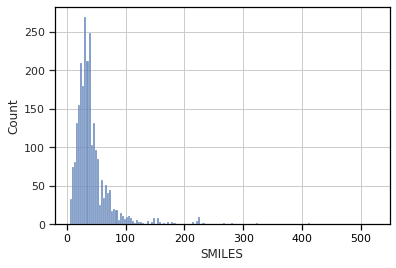

In [ ]:
sns.histplot(df[df["origin"] == "BMDMS-NP"]["SMILES"].value_counts())

<AxesSubplot: xlabel='SMILES', ylabel='Count'>

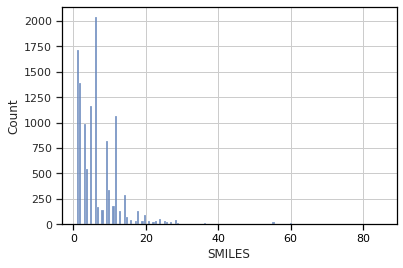

In [ ]:
sns.histplot(df[df["origin"] != "BMDMS-NP"]["SMILES"].value_counts())

<AxesSubplot: xlabel='origin', ylabel='Count'>

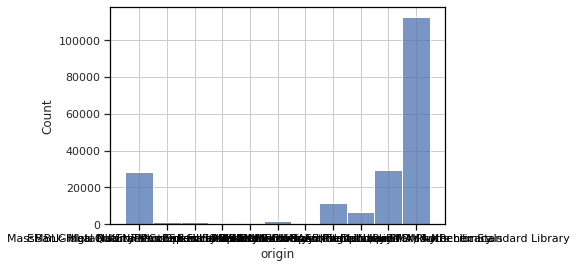

In [ ]:
#sns.catplot(data=df, x="origin")
sns.histplot(data=df, x="origin")

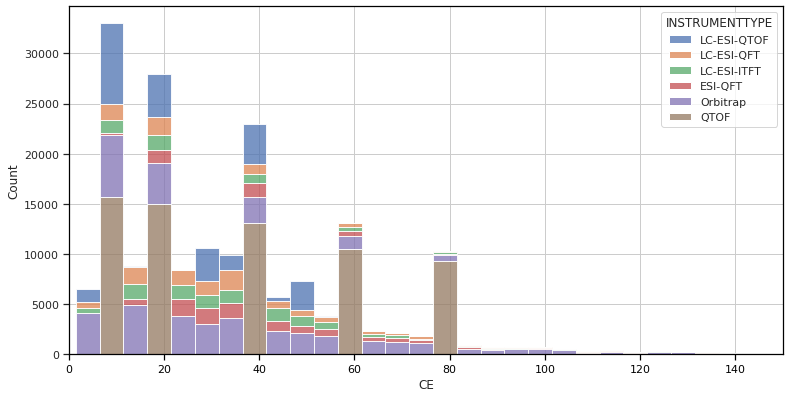

(193438, 28)


In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12.8, 6.4), sharey=False)


top_instrumenttypes = df['INSTRUMENTTYPE'].value_counts().head(6).index
sns.histplot(data=df[df['INSTRUMENTTYPE'].isin(top_instrumenttypes)], x="CE", hue="INSTRUMENTTYPE", multiple="stack", binwidth=5, kde=False)
plt.xlim([0, 150])
plt.show()
print(df.shape)